In [1]:
from jax_elo.models.correlated_skills_model import fit, calculate_ratings, predict, get_player_skill_history

# TODO: Get data from the repo instead
from tdata.functional.sackmann import get_data

/Users/ingramm/miniconda3/envs/tf/lib/python3.7/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
data = get_data('/Users/ingramm/Projects/tennis/tennis-data/data/sackmann/tennis_atp/')

In [25]:
to_use = data[data['tourney_date'].dt.year >= 2016]
to_use = to_use.dropna(subset=['spw_winner', 'spw_loser'])

In [26]:
margins = to_use['spw_winner'] - to_use['spw_loser']

In [27]:
params, opt_info = fit(to_use['winner_name'], to_use['loser_name'], to_use['surface'].values, 
                       margins=margins.values, verbose=True)

{'a1': 0.010000000000000002, 'a2': array(0.), 'sigma_obs': 0.1}
[[10000.000001     0.           0.      ]
 [    0.       10000.000001     0.      ]
 [    0.           0.       10000.000001]]
{'a1': Traced<ShapedArray(float64[])>with<JVPTrace(level=1/1)>
  with primal = Traced<ShapedArray(float64[]):JaxprTrace(level=-1/1)>
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=0/1)>, 'a2': Traced<ShapedArray(float64[])>with<JVPTrace(level=1/1)>
  with primal = Traced<ShapedArray(float64[]):JaxprTrace(level=-1/1)>
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=0/1)>, 'sigma_obs': Traced<ShapedArray(float64[])>with<JVPTrace(level=1/1)>
  with primal = Traced<ShapedArray(float64[]):JaxprTrace(level=-1/1)>
       tangent = Traced<ShapedArray(float64[]):JaxprTrace(level=0/1)>}
Traced<ShapedArray(float64[3,3])>with<JVPTrace(level=1/1)>
  with primal = Traced<ShapedArray(float64[3,3]):JaxprTrace(level=-1/1)>
       tangent = Traced<ShapedArray(float64[3,3]):JaxprTrace

{'a1': 0.00015546114254641995, 'a2': array(0.09785603), 'sigma_obs': 0.08118202951820358}
[[ 7528.17822986  4397.28793945  5218.01945579]
 [ 4397.28793945 13713.68253442  7613.62078847]
 [ 5218.01945579  7613.62078847  7396.731839  ]]
{'a1': 0.00015575839107705638, 'a2': array(0.09784999), 'sigma_obs': 0.08119749168175507}
[[ 7633.63428071  4413.42204334  5299.78827425]
 [ 4413.42204334 12829.6234352   7452.41730331]
 [ 5299.78827425  7452.41730331  7363.30983796]]
{'a1': 0.0001555584894656302, 'a2': array(0.09786549), 'sigma_obs': 0.08121008527423224}
[[ 7611.46580836  4443.937784    5340.91836719]
 [ 4443.937784   12587.92095443  7477.84486909]
 [ 5340.91836719  7477.84486909  7376.41677427]]
{'a1': 0.00015520843426457585, 'a2': array(0.09788812), 'sigma_obs': 0.08122284283857628}
[[ 7522.82851031  4481.60932027  5364.61301489]
 [ 4481.60932027 12520.01345109  7573.22265744]
 [ 5364.61301489  7573.22265744  7404.94386237]]
{'a1': 0.0001551593353824197, 'a2': array(0.09789196), 'sigma

In [28]:
params

EloParams(theta={'a1': 0.0001555460350764931, 'a2': array(0.09787823), 'sigma_obs': 0.08122106071618303}, cov_mat=DeviceArray([[ 7458.7055678 ,  4481.57967465,  5253.92247977],
             [ 4481.57967465, 12350.91436939,  7614.25277   ],
             [ 5253.92247977,  7614.25277   ,  7400.98129021]],            dtype=float64))

In [29]:
params.theta['a1']

0.0001555460350764931

In [30]:
history, final_rating_dict, mark_names = calculate_ratings(params, to_use['winner_name'], to_use['loser_name'],
                                            to_use['surface'].values, margins.values)

100%|██████████| 10841/10841 [00:11<00:00, 949.58it/s] 


In [31]:
history[-1]

{'winner': 'Thiago Seyboth Wild',
 'loser': 'Casper Ruud',
 'winner_prior_mean': {'Clay': 1547.498469241016,
  'Grass': 1528.5395598998512,
  'Hard': 1533.4579871844603},
 'loser_prior_mean': {'Clay': 1767.6062863520092,
  'Grass': 1622.269498834001,
  'Hard': 1653.299511690967},
 'winner_prior_prob': 0.23875966578242916,
 'cur_mark': 'Clay'}

In [32]:
predict(final_rating_dict, params, 'Roger Federer', 'Tennys Sandgren', 'Hard', mark_names)

0.9211069909895352

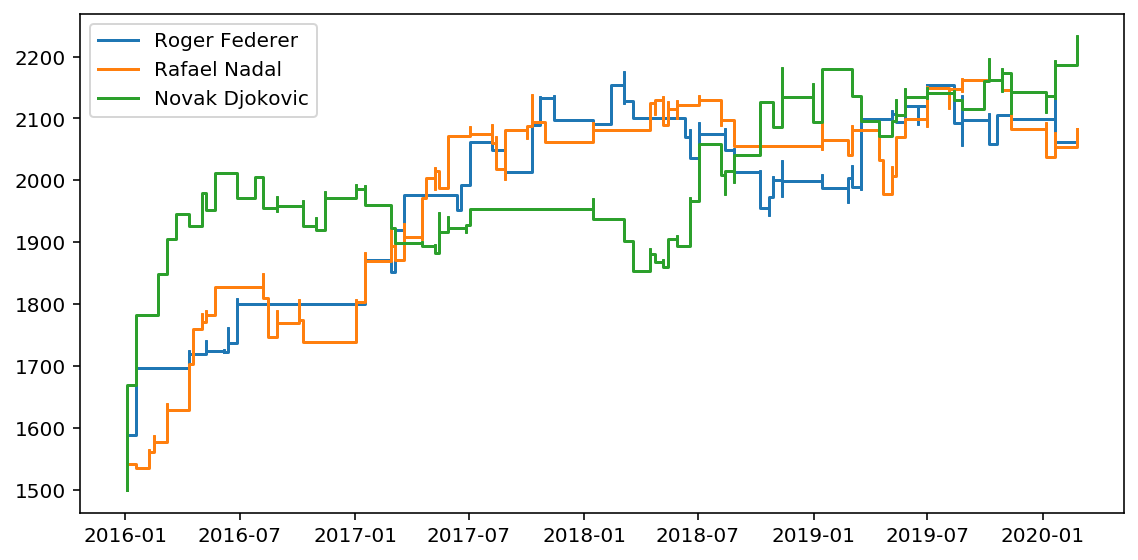

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

f, ax = plt.subplots(1, 1)

start_year = 2012
surface = 'Hard'

for cur_player in ['Roger Federer', 'Rafael Nadal', 'Novak Djokovic']:

    cur_history = get_player_skill_history(history, final_rating_dict, to_use['tourney_date'].values, cur_player)
    cur_history = cur_history[cur_history.index >= f'{start_year}-01-01']
    ax.step(cur_history.index, cur_history[surface].values, label=cur_player)
    
ax.legend()

f.set_size_inches(8, 4)
f.tight_layout()

In [35]:
import numpy as np
import pandas as pd

prior_sd = pd.Series(np.sqrt(np.diag(params.cov_mat)), mark_names)
print(prior_sd)

Clay      86.363798
Grass    111.134668
Hard      86.028956
dtype: float64
